# Хоррор-фильмы на IMDB: исследовательский анализ данных. Описание проекта.

Ссылка на Kaggle: https://www.kaggle.com/datasets/shreyanshverma27/imdb-horror-chilling-movie-dataset


Оригинальное описание:


The IMDb Horror Movie Dataset is a comprehensive collection that opens the doors to a rich and captivating realm of horror cinema. This dataset presents a trove of information on spine-chilling films, enabling enthusiasts, researchers, and data scientists to explore and analyze the intriguing world of horror movies.

The dataset consists of eight essential columns, each providing valuable details to delve into the depths of the horror genre:

Movie Title: This column holds the names of the horror movies, acting as unique identifiers for each entry. From iconic classics to modern masterpieces, this dataset covers a wide range of eerie titles.

Movie Year: The year of release provides a temporal perspective, allowing researchers to observe how horror movies have evolved over time. Uncover trends, shifts in storytelling, and the impact of societal influences on the genre.

Runtime: Discover the duration of each horror movie. Analyze movie lengths to identify patterns and explore potential correlations between runtime and audience reception.

Genre: Delve into the diverse range of horror subgenres represented in this dataset. From supernatural and psychological thrillers to slasher films and creature features, the genre column allows for in-depth analysis of thematic variations.

Rating: Explore the overall ratings assigned to horror movies by IMDb users. Assess critical and audience reception, uncover highly acclaimed films, and identify hidden gems in the horror genre.

Director: Gain insights into the minds behind the terror. The director column reveals the names of the visionary filmmakers who crafted these spine-tingling experiences. Investigate the works of renowned horror directors and examine their stylistic choices.

Votes: Understand the level of audience engagement by examining the number of votes each movie has received on IMDb. Analyze the popularity and reach of different horror movies, identifying fan favorites and cult classics.

Gross: Explore the financial success of horror movies with the gross column. Discover which films have resonated with audiences and generated significant box office earnings.

With this dataset, users can embark on a journey to unravel horror movie trends, dissect audience preferences, and examine the impact of various factors on the success of horror films. Researchers can analyze the influence of directors, genre preferences across different years, correlations between runtime and ratings, or investigate the relationship between box office performance and critical acclaim.

# Загрузка данных.

Загружаем необходимые нам библиотеки.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

Загружаем данные, смотрим информацию о них.

In [ ]:
df = pd.read_csv('/Datasets/Horror_Movies_IMDb.csv', sep = ',')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Movie Title  836 non-null    object 
 1   Movie Year   836 non-null    int64  
 2   Runtime      836 non-null    int64  
 3   Genre        836 non-null    object 
 4   Rating       836 non-null    float64
 5   Director     836 non-null    object 
 6   Votes        836 non-null    object 
 7   Gross        637 non-null    object 
dtypes: float64(1), int64(2), object(5)
memory usage: 52.4+ KB


In [ ]:
df.head()

,Movie Title,Movie Year,Runtime,Genre,Rating,Director,Votes,Gross
0,Alien,1979,117,"Horror, Sci-Fi",8.5,Ridley Scott,"9,05,275",$78.90M
1,Psycho,1960,109,"Horror, Mystery, Thriller",8.5,Alfred Hitchcock,"6,89,068",$32.00M
2,The Shining,1980,146,"Drama, Horror",8.4,Stanley Kubrick,"10,51,582",$44.02M
3,The Thing,1982,109,"Horror, Mystery, Sci-Fi",8.2,John Carpenter,"4,39,793",$13.78M
4,Tumbbad,2018,104,"Drama, Fantasy, Horror",8.2,Rahi Anil Barve,"53,297",NaN


In [ ]:
df.describe()

,Movie Year,Runtime,Rating
count,836.000000,836.000000,836.000000
mean,2004.271531,100.767943,6.160167
std,16.330837,14.484556,0.940355
min,1920.000000,57.000000,1.600000
25%,1998.000000,91.000000,5.600000
50%,2009.000000,98.000000,6.200000
75%,2016.000000,108.000000,6.800000
max,2023.000000,191.000000,8.500000


Смотрим количество пропусков по столбцам.

In [ ]:
pd.DataFrame(
    round(
        df.isna().mean() * 100,
    )
).style.background_gradient('coolwarm')

,0
Movie Title,0.000000
Movie Year,0.000000
Runtime,0.000000
Genre,0.000000
Rating,0.000000
Director,0.000000
Votes,0.000000
Gross,24.000000


Проверяем датасет на явные дубликаты.

In [ ]:
df.duplicated().sum()

0

Часть строк датасета содержат пропуски, поэтому проверим датасет на неявные дубликаты.

In [ ]:
df.duplicated(subset=['Movie Title', 'Movie Year'], keep=False).sum()

0

## Выводы по разделу.

- Необходимые библиотеки и данные загружены.

- Выведена информация о датасете.

- У столбцов  Votes и Gross неправильный тип данных, первый нужно перевести в int, второй в float.

- В столбце Gross 24% пропусков, которые нужно заполнить. Вызваны они, скорее всего, неправильным составлением датасета.

# Подготовка данных.

Заменяем типы данных столбцов Votes и Gross в int и float соответственно.

In [ ]:
df['Votes'] = df['Votes'].replace({',': ''}, regex=True).astype(int)

In [ ]:
df['Gross'] = df['Gross'].replace({'\$': '', 'M': ''}, regex=True).astype(float)

Проверяем.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Movie Title  836 non-null    object 
 1   Movie Year   836 non-null    int64  
 2   Runtime      836 non-null    int64  
 3   Genre        836 non-null    object 
 4   Rating       836 non-null    float64
 5   Director     836 non-null    object 
 6   Votes        836 non-null    int64  
 7   Gross        637 non-null    float64
dtypes: float64(2), int64(3), object(3)
memory usage: 52.4+ KB


Пропуски в столбце Gross будет целесообразно заменить на медианое значение фильмов с аналогичным рейтингом. Напишем для этого функцию и применем её.

In [ ]:
def fill_gross_nan_with_median(df):
    median_by_rating = df.groupby('Rating')['Gross'].median()
    df['Gross'] = df.apply(
        lambda row: median_by_rating[row['Rating']]
        if pd.isnull(row['Gross'])
        else row['Gross'],
        axis=1,
    )
    return df

df = fill_gross_nan_with_median(df)

Делаем проверку.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Movie Title  836 non-null    object 
 1   Movie Year   836 non-null    int64  
 2   Runtime      836 non-null    int64  
 3   Genre        836 non-null    object 
 4   Rating       836 non-null    float64
 5   Director     836 non-null    object 
 6   Votes        836 non-null    int64  
 7   Gross        832 non-null    float64
dtypes: float64(2), int64(3), object(3)
memory usage: 52.4+ KB


Осталось 4 пропуска: фильмы, для которого не нашлось аналогов по рейтингу в данном датасете. Удаляем строки с ними.

In [ ]:
df = df.dropna(subset=['Gross'])

Делаем финальную проверку.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 832 entries, 0 to 834
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Movie Title  832 non-null    object 
 1   Movie Year   832 non-null    int64  
 2   Runtime      832 non-null    int64  
 3   Genre        832 non-null    object 
 4   Rating       832 non-null    float64
 5   Director     832 non-null    object 
 6   Votes        832 non-null    int64  
 7   Gross        832 non-null    float64
dtypes: float64(2), int64(3), object(3)
memory usage: 58.5+ KB


In [ ]:
df.describe()

,Movie Year,Runtime,Rating,Votes,Gross
count,832.000000,832.000000,832.000000,8.320000e+02,832.000000
mean,2004.299279,100.771635,6.177404,1.008023e+05,32.038486
std,16.292545,14.409375,0.907990,1.084566e+05,36.484012
min,1920.000000,57.000000,2.100000,2.503700e+04,0.000000
25%,1998.000000,91.000000,5.600000,3.820625e+04,11.170000
50%,2009.000000,98.500000,6.200000,6.088150e+04,24.040000
75%,2016.000000,108.000000,6.800000,1.204312e+05,39.812500
max,2023.000000,191.000000,8.500000,1.051582e+06,411.330000


Есть фильмы с нулевыми кассовыми сборами. Природа этих нулей аналогична пропускам. Заполним их так же медианным значением, согласно их рейтингу.

In [ ]:
def fill_gross_null_with_median(df):
    median_by_rating = df.groupby('Rating')['Gross'].median()
    df['Gross'] = df.apply(
        lambda row: median_by_rating[row['Rating']]
        if row['Gross'] == 0
        else row['Gross'],
        axis=1,
    )
    return df

df = fill_gross_null_with_median(df)

С численными данным разобрались. Теперь рассмотрим, какие поджанры фильмов ужасов приведены в нашем датасете.

In [ ]:
df['Genre'].unique()

array(['Horror, Sci-Fi', 'Horror, Mystery, Thriller', 'Drama, Horror',
       'Horror, Mystery, Sci-Fi', 'Drama, Fantasy, Horror', 'Horror',
       'Crime, Drama, Horror', 'Drama, Horror, Thriller',
       'Drama, Horror, Mystery', 'Comedy, Horror', 'Fantasy, Horror',
       'Adventure, Horror, Sci-Fi', 'Action, Adventure, Horror',
       'Action, Crime, Horror', 'Horror, Thriller',
       'Drama, Horror, Sci-Fi', 'Action, Horror, Thriller',
       'Action, Comedy, Horror', 'Animation, Action, Drama',
       'Comedy, Drama, Horror', 'Action, Crime, Drama', 'Horror, Mystery',
       'Comedy, Fantasy, Horror', 'Comedy, Horror, Musical',
       'Crime, Horror, Mystery', 'Comedy, Horror, Mystery',
       'Action, Horror', 'Drama, Horror, Musical',
       'Fantasy, Horror, Mystery', 'Comedy, Horror, Sci-Fi',
       'Action, Adventure, Drama', 'Comedy, Horror, Thriller',
       'Adventure, Horror, Thriller', 'Action, Horror, Sci-Fi',
       'Action, Drama, Horror', 'Biography, Crime, Drama',

Есть фильм с жанрами ввроде 'Action, Adventure, Drama', которые либо изначально не имеют отношение к нашим данным и попали сюда по ошибке, либо были непрравильно отмечены при сборе информации. Оставим в датасете только те поджанры, которые в своих названиях имеют слово Horror.

In [ ]:
df = df[df['Genre'].str.contains('Horror')]

Делаем проверку.

In [ ]:
df['Genre'].unique()

array(['Horror, Sci-Fi', 'Horror, Mystery, Thriller', 'Drama, Horror',
       'Horror, Mystery, Sci-Fi', 'Drama, Fantasy, Horror', 'Horror',
       'Crime, Drama, Horror', 'Drama, Horror, Thriller',
       'Drama, Horror, Mystery', 'Comedy, Horror', 'Fantasy, Horror',
       'Adventure, Horror, Sci-Fi', 'Action, Adventure, Horror',
       'Action, Crime, Horror', 'Horror, Thriller',
       'Drama, Horror, Sci-Fi', 'Action, Horror, Thriller',
       'Action, Comedy, Horror', 'Comedy, Drama, Horror',
       'Horror, Mystery', 'Comedy, Fantasy, Horror',
       'Comedy, Horror, Musical', 'Crime, Horror, Mystery',
       'Comedy, Horror, Mystery', 'Action, Horror',
       'Drama, Horror, Musical', 'Fantasy, Horror, Mystery',
       'Comedy, Horror, Sci-Fi', 'Comedy, Horror, Thriller',
       'Adventure, Horror, Thriller', 'Action, Horror, Sci-Fi',
       'Action, Drama, Horror', 'Horror, Sci-Fi, Thriller',
       'Horror, Mystery, Romance', 'Crime, Horror, Thriller',
       'Drama, Horror, 

## Выводы по разделу.

- Неверные типы данных заменены на верные. Теперь количество голосов пользователей - это целые числа, доход от фильма - дробное (в миллионах долларов).
- Пропуски обработаны: большая часть заменена на медианое значение доходов от фильмов с аналогичным рейтингом, оставшиеся удалены. Аналогично поступили с фильмами, имевшими в таблице нулевые кассовые сборы, так как данное значение в нашем случае соответствует пропуску.
- Из датасета удалены все фильмы, указанный жанр которых не соответствует теме нашего исследования.

# Исследование данных.

Построим графики распределения кассовых сборов, голосов пользователей, рейтинга и года выпуска по фильмам.

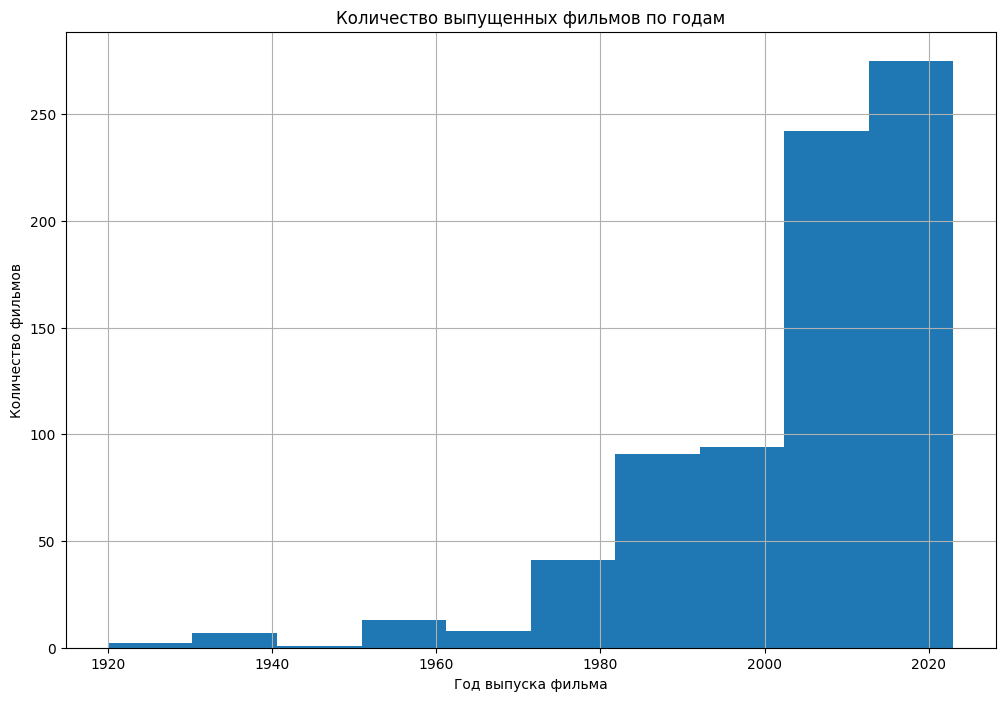

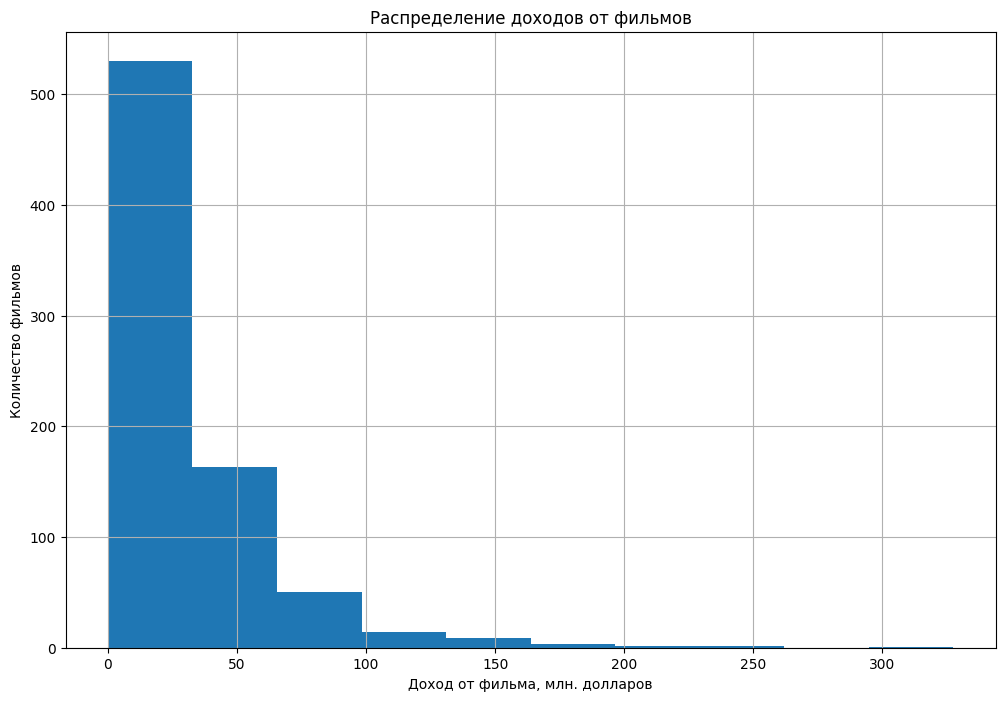

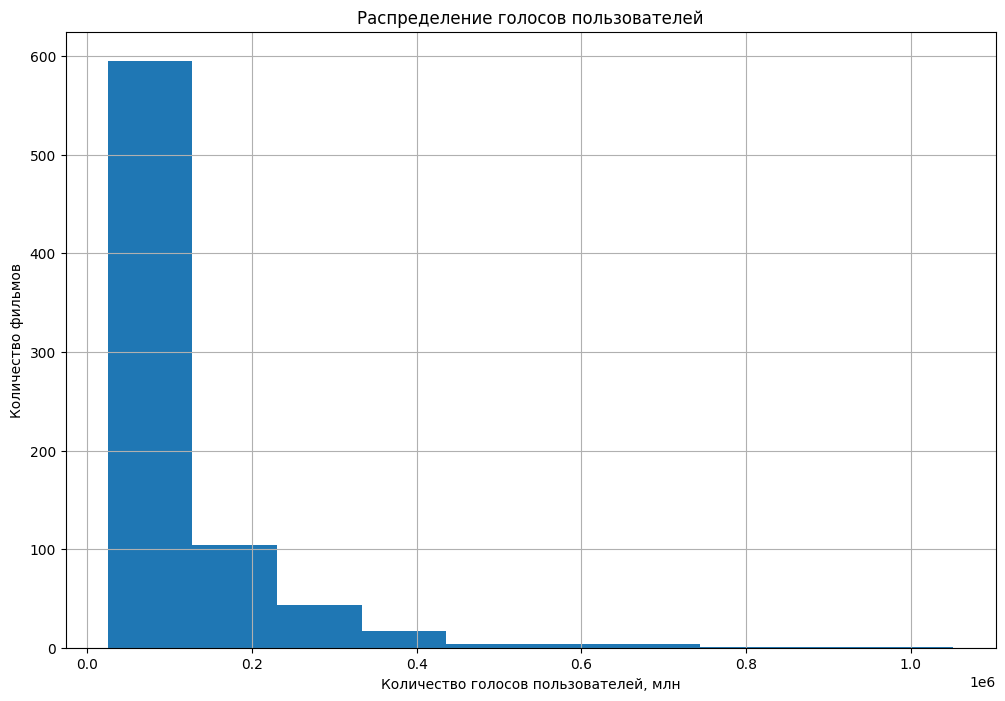

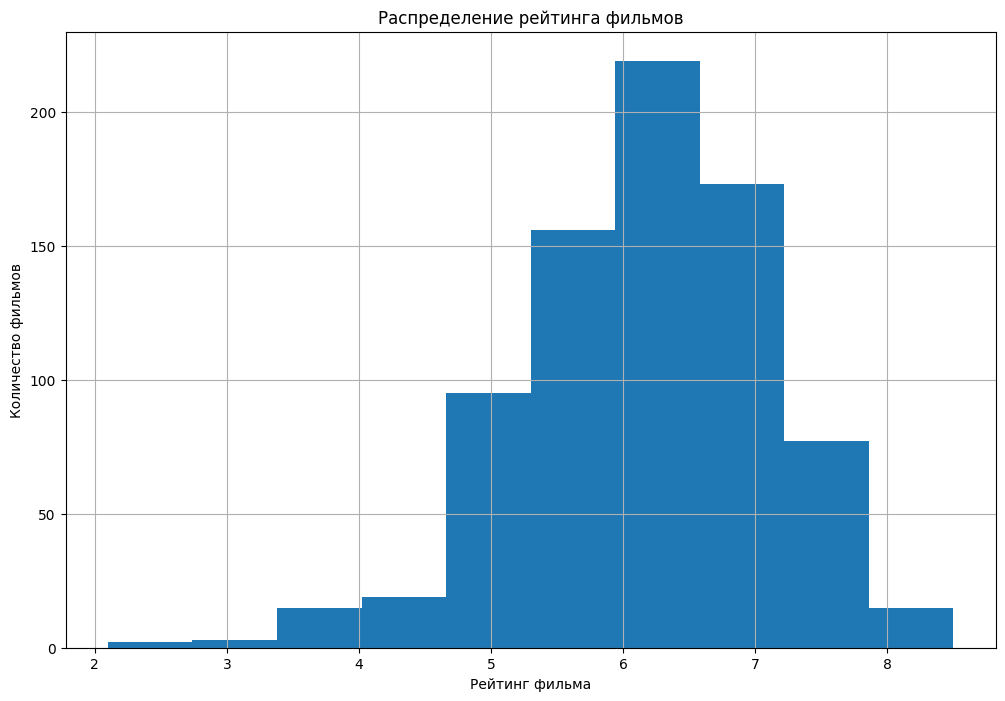

In [ ]:
def plot_histogram(data, xlabel, ylabel, title):
    plt.figure(figsize=(12, 8))
    data.hist()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    print()


plot_histogram(
    df['Movie Year'],
    'Год выпуска фильма',
    'Количество фильмов',
    'Количество выпущенных фильмов по годам',
)
plot_histogram(
    df['Gross'],
    'Кассовые сборы, млн. долларов',
    'Количество фильмов',
    'Распределение кассовых сборов',
)
plot_histogram(
    df['Votes'],
    'Количество голосов пользователей, млн',
    'Количество фильмов',
    'Распределение голосов пользователей',
)
plot_histogram(
    df['Rating'],
    'Рейтинг фильма',
    'Количество фильмов',
    'Распределение рейтинга фильмов',
)

Из графиков видно следующее:
- Индустрия фильмов ужасов растёт, фильмов снимается всё больше и больше. Причём сильный скачок был в нулевых. Полагаю, что причиной этому стал ряд фильмов с высокими кассовыми сборами, повысивших интерес зрителей к хоррорам, а инвесторов к вложению денег в создание новых фильмов данного жанра.
- По кассовым сборам большинство фильмов не преодолевает границу в 50 млн долларов. Границу в 200 млн долларов преодолели единицы.
- Шедевров, получивших высокие рейтинги и оценки пользователей, не так много. Больше всего фильмов, имеющих рейтинг 6.5 из 10 и мене 100000 лайков от пользователей.

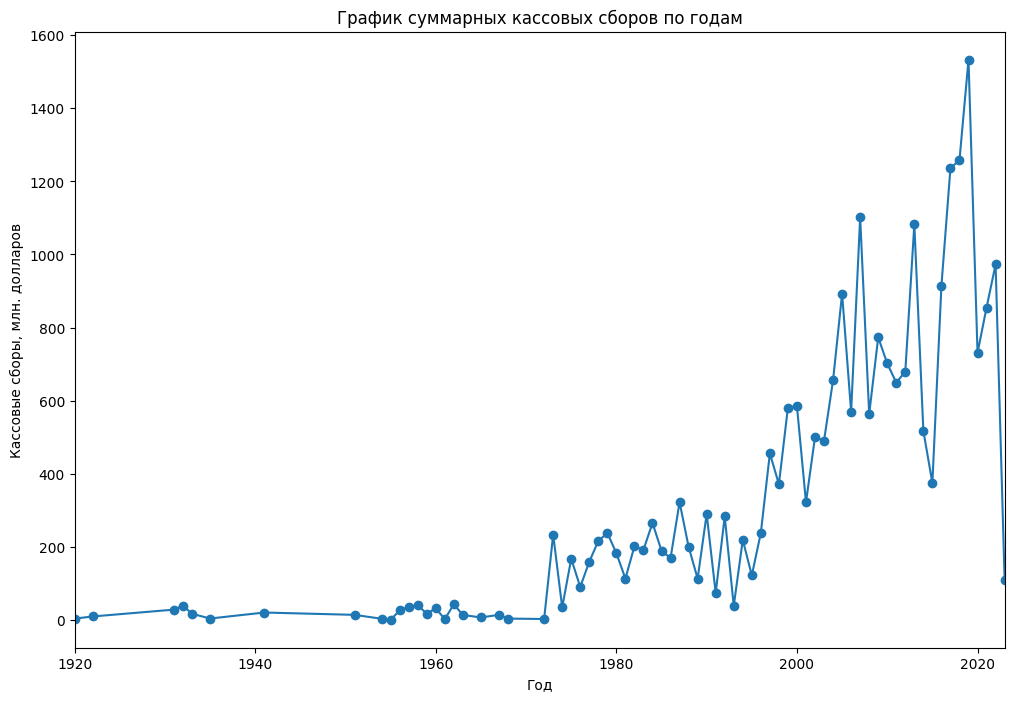

In [ ]:
grouped_data = df.groupby('Movie Year')['Gross'].sum().reset_index()

plt.figure(figsize=(12, 8))
plt.plot(grouped_data['Movie Year'], grouped_data['Gross'], 'o-')

plt.xlabel('Год')
plt.ylabel('Кассовые сборы, млн долларов')
plt.title('График суммарных кассовых сборов по годам')
plt.xlim(1920, 2023)

plt.show()

In [ ]:
df.groupby('Movie Year')['Gross'].sum().reset_index()

,Movie Year,Gross
0,1920,4.050
1,1922,10.000
2,1931,28.715
3,1932,39.870
4,1933,17.365
...,...,...
68,2019,1532.210
69,2020,730.715
70,2021,854.555
71,2022,972.640


Больше фильмов - больше суммарные кассовые сборы от этих фильмов. Сильный рост, хотя и с периодическими провалами, пошёл опять же с нулевых, когда начали снимать больше фильмов исследуемого жанра. Максимальная суммарная выручка (1.5 миллиарда долларов) была в 2019 году. Прошлый 2022-ой год суммарно принём 972 миллиона. Скачок вниз в самом конце графика объясняется тем, что за текущий 2023-ий год вышли ещё не все фильмы ужасов, которые должны это сделать, соответственно, собрана не вся информация.

Теперь рассмотрим распределение поджанров. Для начала определим, каких фильмов было снято больше всего.

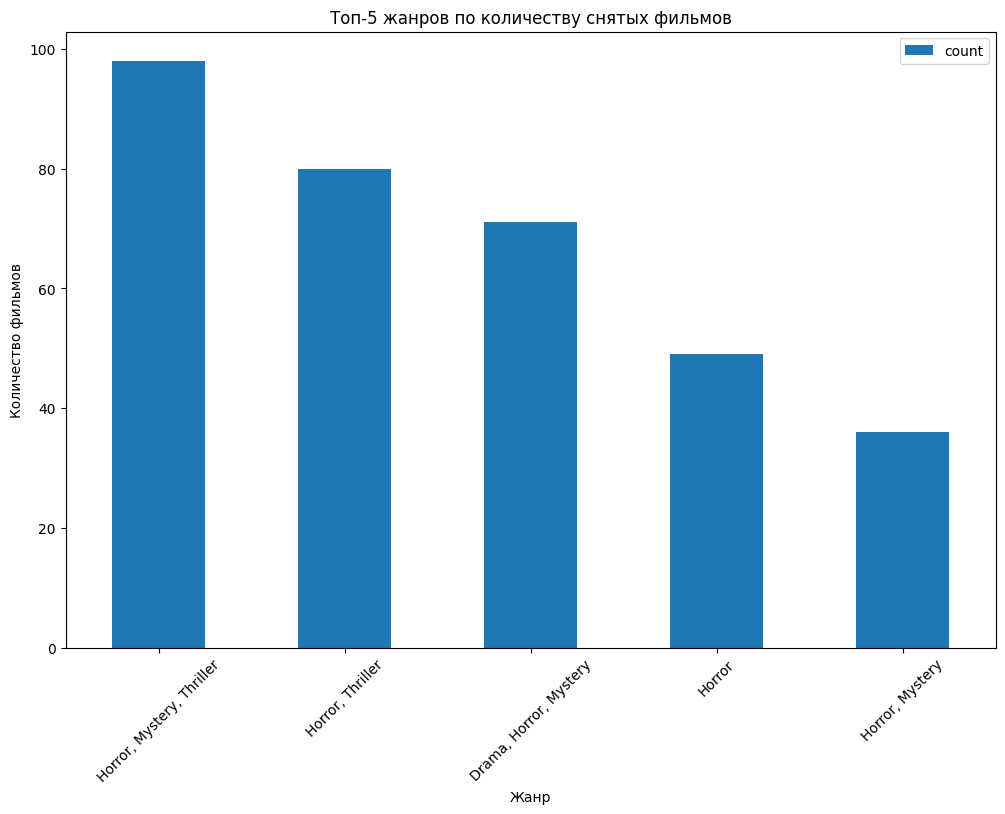

In [ ]:
genre_counts = (
    df.groupby('Genre')['Gross']
    .agg(['count'])
    .sort_values(by='count', ascending=False)
    .head()
)

fig, ax = plt.subplots(figsize=(12, 8))
genre_counts.plot(kind='bar', ax=ax)

ax.set_xlabel('Жанр')
ax.set_ylabel('Количество фильмов')
ax.set_title('Топ-5 жанров по количеству снятых фильмов')

plt.xticks(rotation=45)
plt.show()

Больше всего снято фильмов, где хоррор соседствует с мистикой\триллером\драмой.

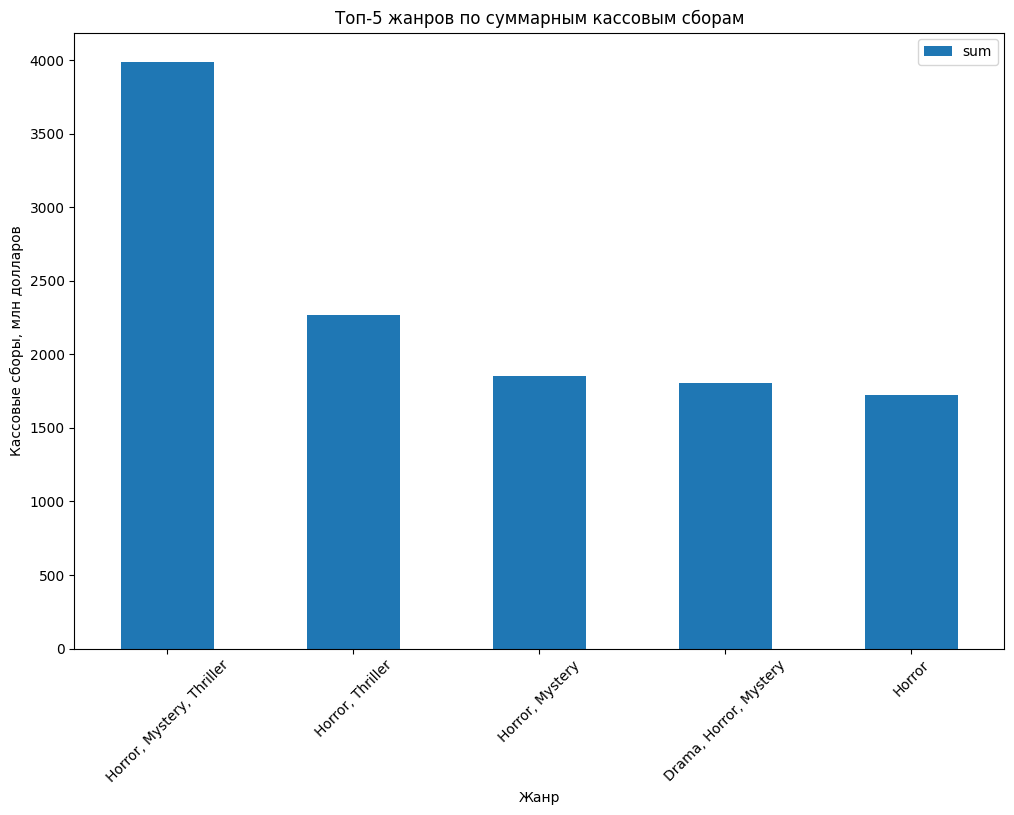

In [ ]:
genre_counts = df.groupby('Genre')['Gross'].agg(['sum']).sort_values(by='sum', ascending=False).head()

fig, ax = plt.subplots(figsize=(12, 8))
genre_counts.plot(kind='bar', ax=ax)

ax.set_xlabel('Жанр')
ax.set_ylabel('Кассовые сборы, млн долларов')
ax.set_title('Топ-5 жанров по суммарным кассовым сборам')

plt.xticks(rotation=45)
plt.show()

Всё логично: фильмы поджанров, которые снимали больше всего, принесли больше денег. Разве что порядок немного поменялся.

Теперь перейдём к анализу информации о конкретных фильмах.

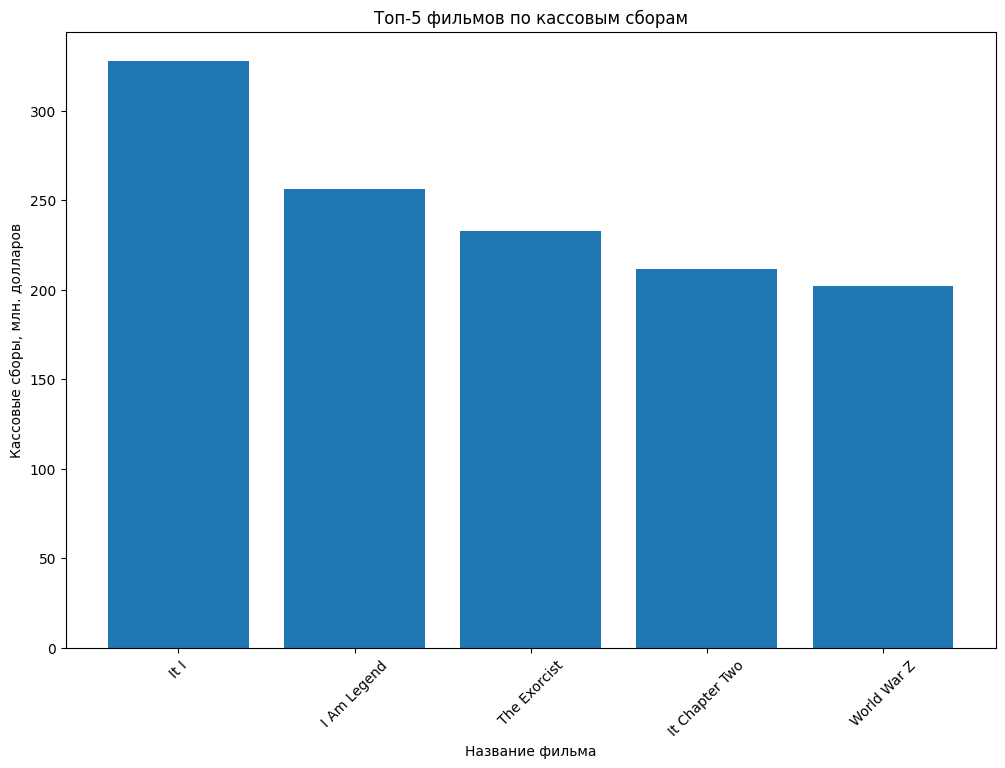

In [ ]:
top_5_gross = df.sort_values(by='Gross', ascending=False).head()

plt.figure(figsize=(12, 8))
plt.bar(top_5_gross['Movie Title'], top_5_gross['Gross'])

plt.xlabel('Название фильма')
plt.ylabel('Кассовые сборы, млн. долларов')
plt.title('Топ-5 фильмов по кассовым сборам')

plt.xticks(rotation=45)

plt.show()

Видим интересный факт: все самые финасово успешные фильмы из нашего датасета основаны на соответствующих книгах. Экранизация 'Оно' Стивена Кинга и вовсе заняла целых две строчки в топе за счёт того, что состояла из двух частей.

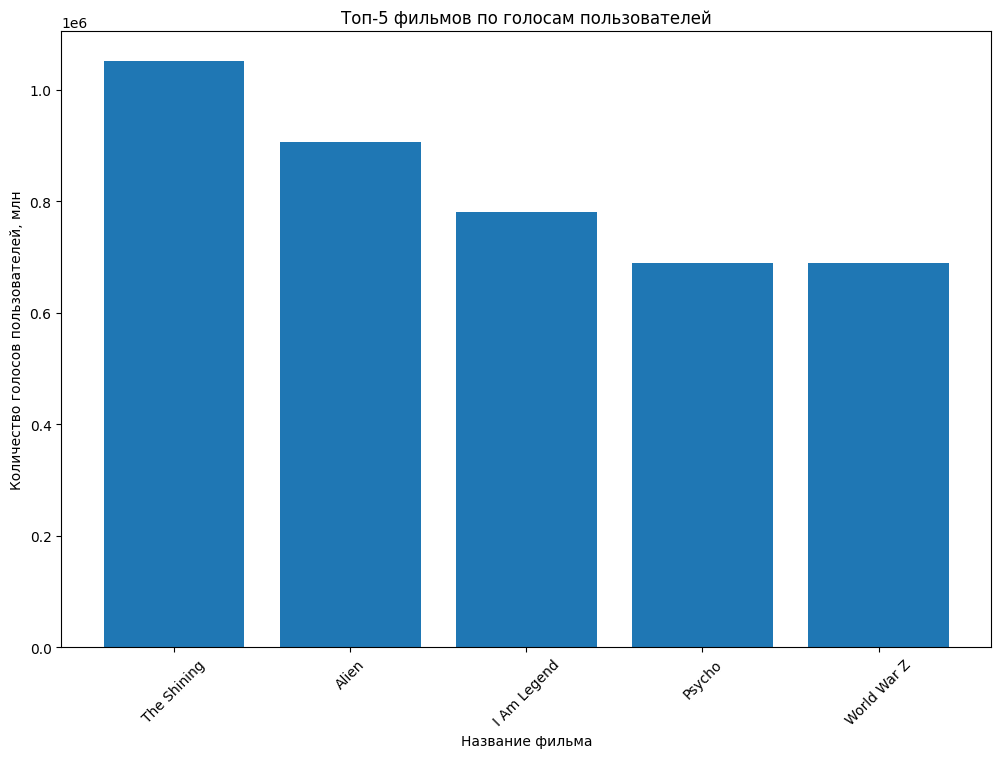

In [ ]:
top_5_votes = df.sort_values(by='Votes', ascending=False).head()

plt.figure(figsize=(12, 8))
plt.bar(top_5_votes['Movie Title'], top_5_votes['Votes'])

plt.xlabel('Название фильма')
plt.ylabel('Количество голосов пользователей, млн')
plt.title('Топ-5 фильмов по голосам пользователей')

plt.xticks(rotation=45)

plt.show()

А вот тут картина частично поменялась. Из предыдущего топ-5 своё место сохранили 'Я - легенда', сдвинувшись на одну ступеньку вниз, и 'Война Миров Z'. Остальные места по голсам пользователей заняли классические 'Сияние', 'Чужой' и 'Психо'.

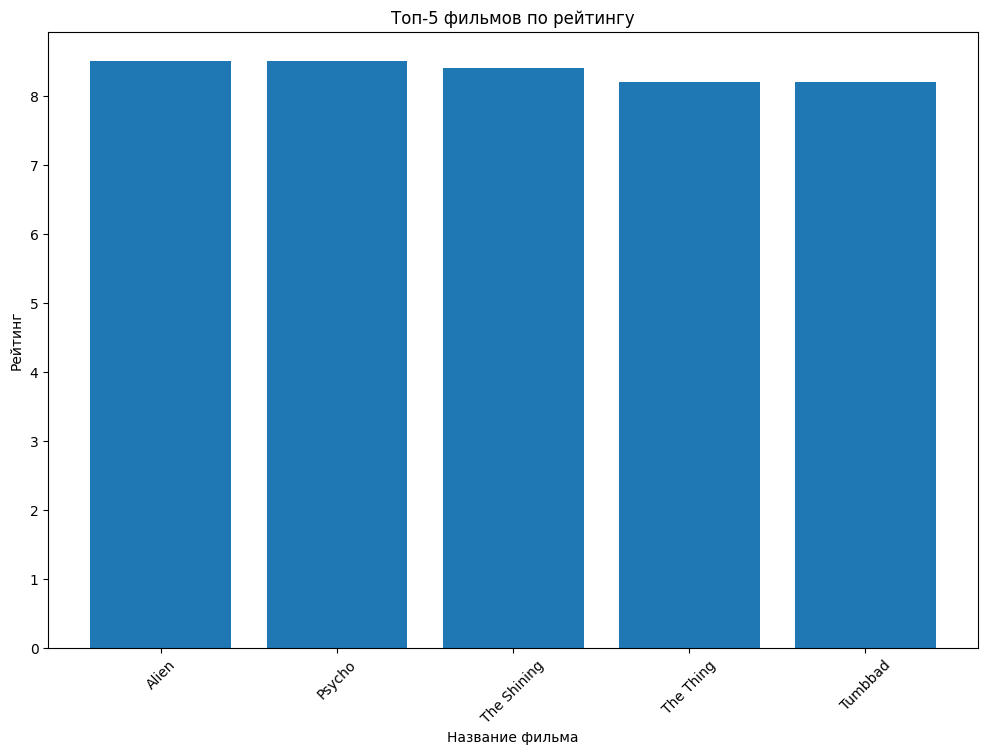

In [ ]:
top_5_rating = df.sort_values(by='Rating', ascending=False).head()

plt.figure(figsize=(12, 8))
plt.bar(top_5_rating ['Movie Title'], top_5_rating['Rating'])

plt.xlabel('Название фильма')
plt.ylabel('Рейтинг')
plt.title('Топ-5 фильмов по рейтингу')

plt.xticks(rotation=45)
plt.show()

Первые три места остались за классикой из предыдущего топа, а вот 'Я - легенда' и 'Война миров Z' ушли, вместо них теперь 'Нечто' (что неудивительно, тоже классика) и, внезапно, индийский хоррор Тумбад.

Теперь рассмотрим информацию по режиссёрам. Для начала посмотрим, чьи фильмы в сумме собрали больше всего денег.

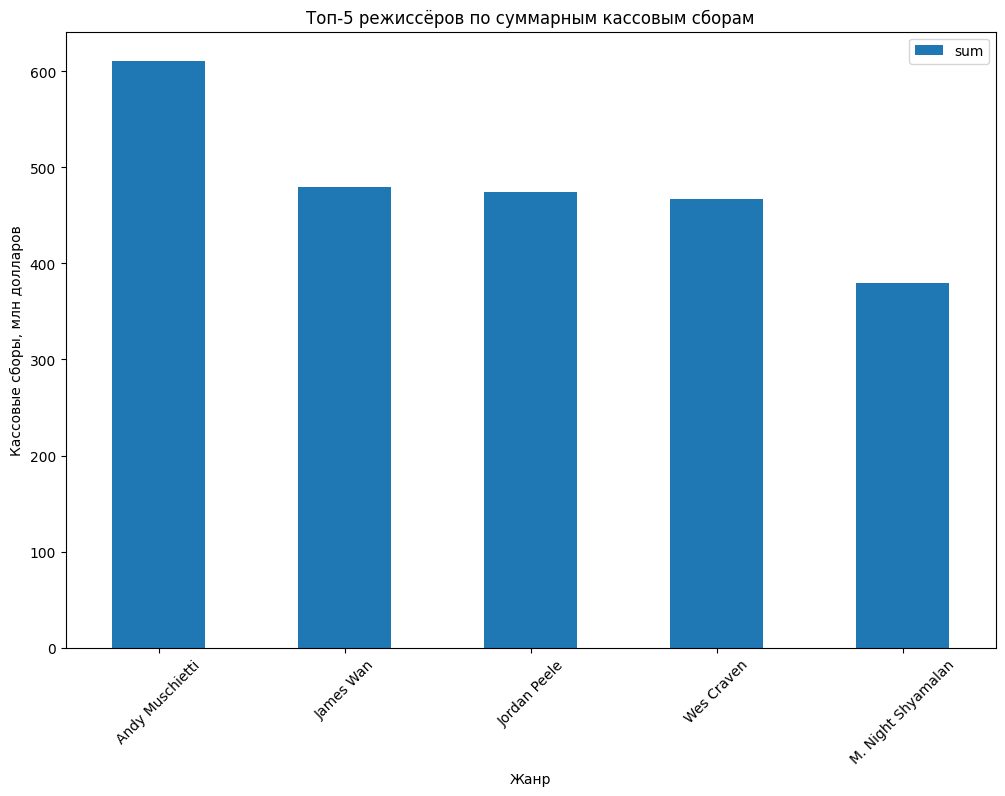

In [ ]:
director_gorss_sum = (
    df.groupby("Director")["Gross"]
    .agg(["sum"])
    .sort_values(by="sum", ascending=False)
    .head()
)

fig, ax = plt.subplots(figsize=(12, 8))
director_gorss_sum.plot(kind="bar", ax=ax)

ax.set_xlabel("Жанр")
ax.set_ylabel("Кассовые сборы, млн долларов")
ax.set_title("Топ-5 режиссёров по суммарным кассовым сборам")

plt.xticks(rotation=45)
plt.show()

Итого, наш топ - 5 режиссёров, чьи фильмы суммарно принесли их создателям больше всего денег:
- Энди Мускетти (неудивительно, его экранизации 'Оно' Кинга как раз и вошли в наш топ самых кассовых фильмов), Джеймс Ван (кинофраншизы «Пила», «Астрал» и «Заклятие» очень успешны).
- Джордан Пил (его фильм получил Оскар в 2018 году за 'лучший оригинальный сценарий').
-  Уэс Крэйвен (кинофраншизы 'Кошмар на улице Вязов', 'Крик' и ещё много работ в жанре хоррор).
- М. Найт Шьямалан, успешно развивающийся в жанре со времён 'Шестого Чувства).

Теперь рассмотрим топ-5 по медианным значениям кассовых сборов. Идея такого топа заключается в том, чтобы посмотреть, чьи киноработы стабильно приносят больше всего денег, несмотря на, возможно, небольшое количество снятых фильмов. Такие режиссёры могут оказаться интересны для потенциальных инвесторов.

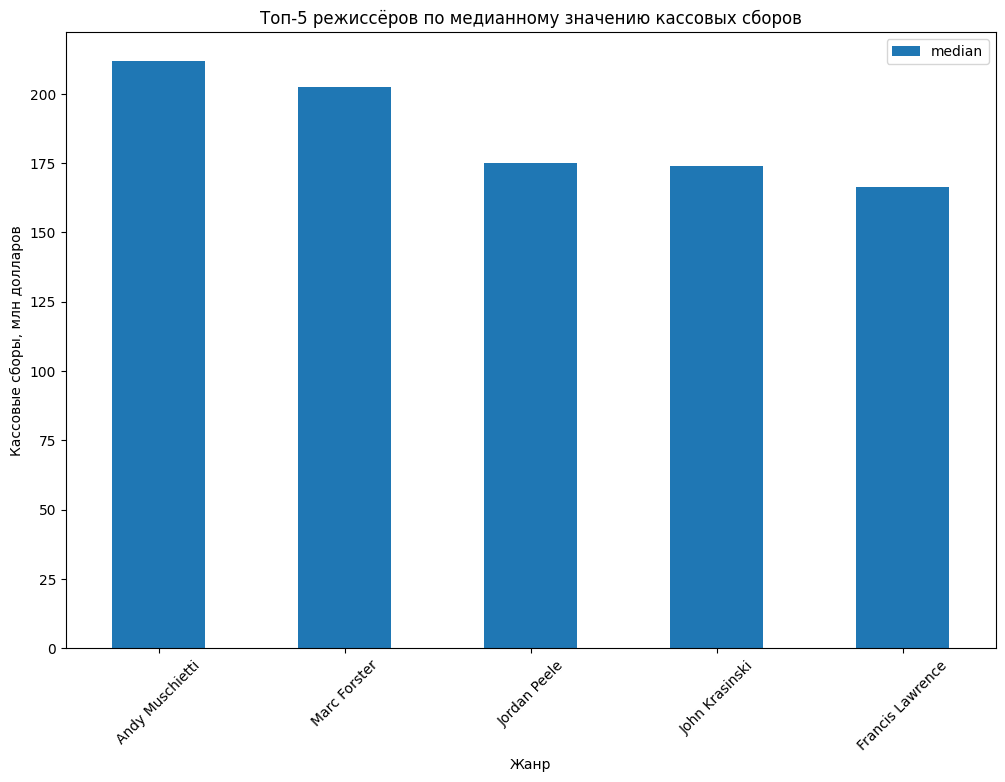

In [ ]:
director_gorss_median = (
    df.groupby('Director')['Gross']
    .agg(['median'])
    .sort_values(by='median', ascending=False)
    .head()
)

fig, ax = plt.subplots(figsize=(12, 8))
director_gorss_median.plot(kind='bar', ax=ax)

ax.set_xlabel('Жанр')
ax.set_ylabel('Кассовые сборы, млн долларов')
ax.set_title('Топ-5 режиссёров по медианному значению кассовых сборов')

plt.xticks(rotation=45)
plt.show()

Видим, что:
- Энди Мускетти сохранил свою лидерскую позицию.
- Марк Форстер попал в топ благодаря всё той же 'Войне миров Z'
- Джордан Пил сохранил своё третье место.
- Джон Крассински не только прекрасен в своей роли из 'Оффиса', но и умеет снимать хорошие хорроры.
- Фрэнсис Лоуренс оказался в топе благодаря фильму 'Я - легенда', который уже побывал в наших топах финансово успешных фильмов.

Теперь отдадим дань уважения режиссёрам, сделавшим наибольший вклад в развитие нашего любимого жанра фильмов. Посмотрим имена тех, кто снял больше всего фильмов, представленных в нашем датасете.

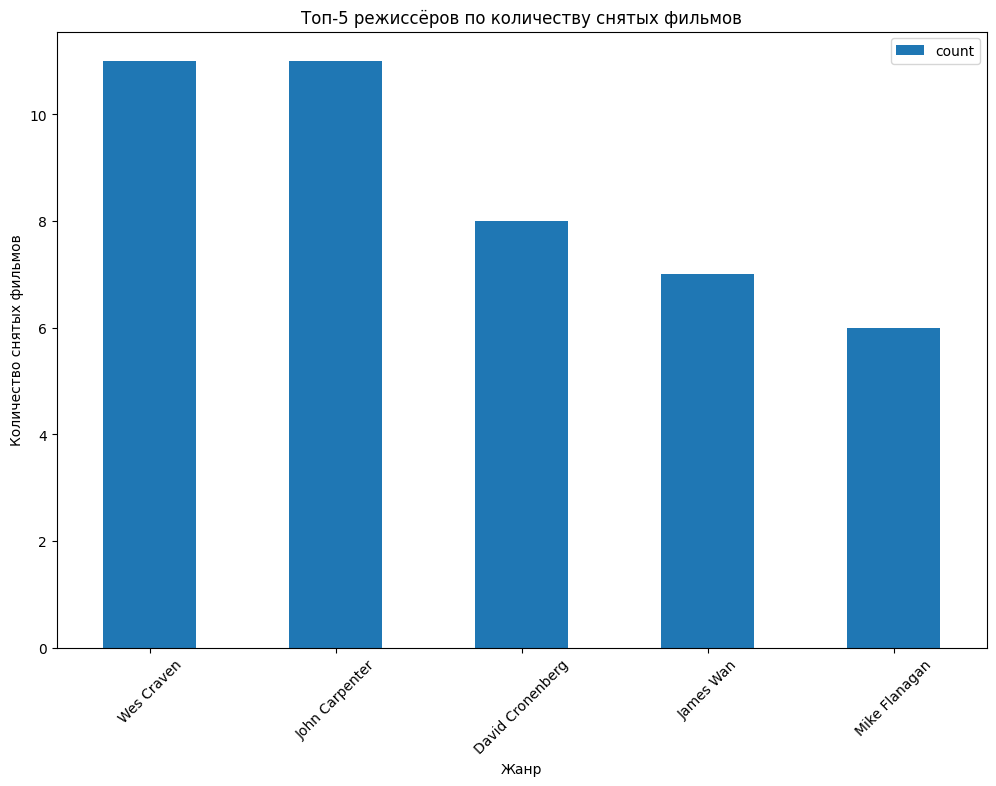

In [ ]:
director_count = (
    df.groupby('Director')['Gross']
    .agg(['count'])
    .sort_values(by='count', ascending=False)
    .head()
)

fig, ax = plt.subplots(figsize=(12, 8))
director_count.plot(kind='bar', ax=ax)

ax.set_xlabel('Жанр')
ax.set_ylabel('Количество снятых фильмов')
ax.set_title('Топ-5 режиссёров по количеству снятых фильмов')

plt.xticks(rotation=45)
plt.show()


Итак, топ-5 самых деятельных режиссёров, работающих в жанре хоррор.

- Уэс Крэйвен. О его успешных кинофраншиза мы уже упоминали выше.

- Джон Карпентер. Мой личный номер один. 'В пасти безумия', 'Князь тьмы', 'Нечто' и многое другое.

- Дэвид Кроненберг. В другие наши топы ни он, ни его работы не попали, но они также важны для жанра. Как любезно подсказывает Википедия, фамилия Кроненберга использовалась как имя нарицательное для боди-хорроров.

- Джеймс Ван. Уже говорили о его работах выше.

- Майк Фланаган. Уже отметился и экранизациями С. Кинга, и целым рядом достаточно качественных хорроров по оригинальным сценариям.

Напоследок посмотрим, в каких поджанрах работали эти режиссёры. Для этого создадим список с их именами, а потом напишем функцию, которая выбирает их фильмы и строит по ним круговую диаграмму процентного соотношения поджанров снятых ими фильмов.

In [ ]:
director_count_list = [
    'Wes Craven',
    'John Carpenter',
    'David Cronenberg',
    'James Wan',
    'Mike Flanagan',
]

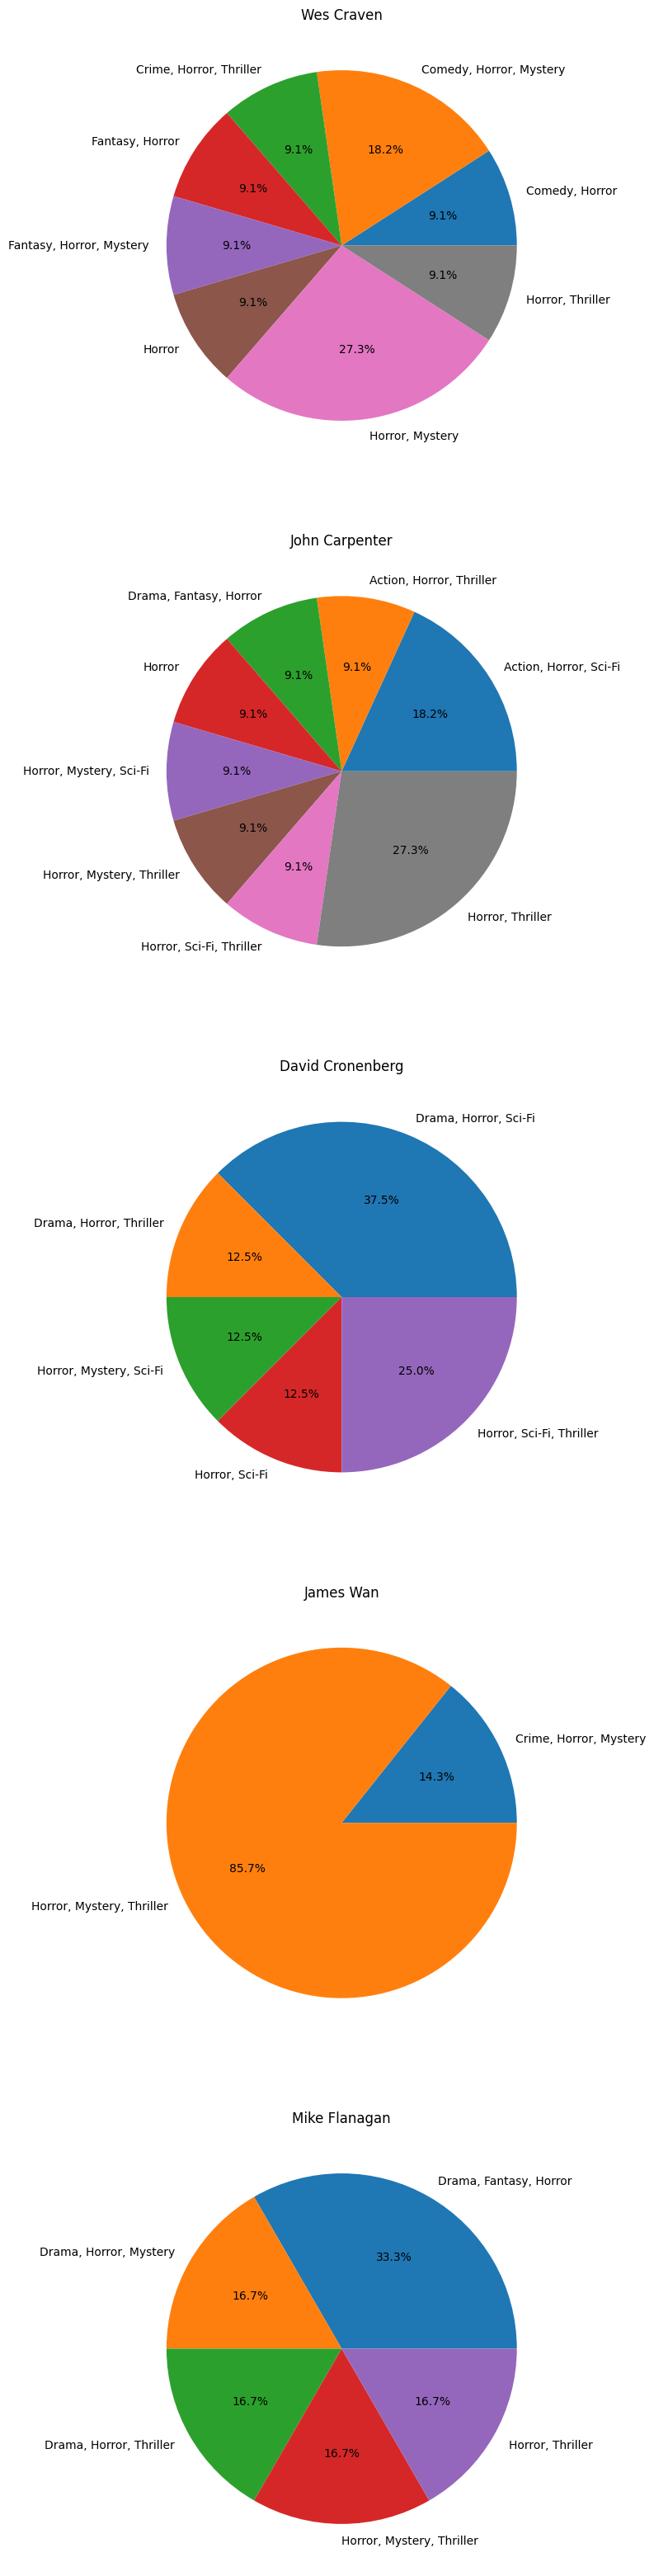

In [ ]:
grouped_df = df.groupby(['Director', 'Genre']).count()

fig, axs = plt.subplots(
    len(director_count_list), 1, figsize=(12, 8 * len(director_count_list))
)

for i, director in enumerate(director_count_list):
    director_df = grouped_df.loc[director]
    counts = [count for count in director_df['Rating']]
    genres = [genre for genre, count in director_df['Rating'].items()]
    title = f'{director}'

    axs[i].pie(counts, labels=genres, autopct='%1.1f%%')
    axs[i].set_title(title)

plt.show()

Что мы видим на графиках:

- Уэс Крэйвен любит добавить к хоррору фэнтези и комедию, также любит мистику.
- Джон Карпентер и Дэвид Кроненберг нашли в своих фильмах место для мотивов научной фантастики, второй к тому же любит драмы.
- Джеймс Ван (кроме достаточно стандартного набора хоррор + мистика + триллер) добавляет в свои фильмы элементы криминальной тематики.
- Майк Фланаган зачастую также не мог обойтись в своих фильмах без элементов драмы.

## Выводы по разделу.

- В рамках данного раздела представленные в датасете фильмы были сгруппированы различным образом, в результате чего были обнаружены закономерности в развитии жанра, финансовой успешности фильмов, их рейтингов и популярности у пользователей сайта, а так же проведён анализ работ конкретных режиссёров.

# Общие выводы.
В рамках этого проекта:
- Были загружены данные, обработаны пропуски в них, типы данных приведены к правильным.
- Датасет был очищен от фильмов, не имеющих отношения (в силу своей жанровой направленности) к теме проекта.
- Было установлено, что количество снятых фильмов ужасов с каждым годом растёт, и активный рост начался с нулевых годов.
- Крайне успешных финасово и по рейтингам\лайкам пользователей сайта не так много: кассовые сборы большинства фильмов не преодолевают границу в 50 млн долларов, рейтинг фильма в среднем находится между 6 и 7 баллами из 10, а неопреодолимой границей по количеству собранных лайков для большинства фильмов из нашего датасета являются 100000.
- Было установлено, что сильный рост суммарных доходов от фильмов пошёл вместе с резким увеличением их количества в нулевых годах. Наданный момент максимальная суммарная выручка (1.5 миллиарда долларов) была собрана в 2019 году. Фильмы за прошлый 2022-ой год собрали 972 миллиона долларов.
- Рассмотрены самые многочисленные и финансово успешные поджанры. Ими оказался вполне ожидаемый набор из хоррора\триллера\мистики\драмы.
- Определены самые финансово успешные фильмы ('Оно' - 327 млн долларов, 'Я - легенда' - 256 млн, 'Изгоняющий дьявола' - 232 млн, 'Оно. Часть 2' - 211 млн, 'Война Миров Z' - 202 млн) и фильмы с наибольшим количеством лайков пользователей \ рейтингом.
- Определены самые кассовые режиссёры, исходя из суммарных сборов их фильмов. Энди Мускетти - 610 млн доллларов, Джеймс Ван - 479 млн, Джордан Пил - 474 млн, Уэс Крэйвен - 466 млн, М. Найт Шьямалан - 379 млн.
- Отдельно рассмотрены режиссёры, чьи фильмы находятся в топе по медианному значению кассовых сборов как перспективные для вложений потенциальных инвесторов. В нём к Энди Мускетти и Джордану Пилу добавились Марк Форестер, чей фильм в среднем приносит 202 млн долларов, Джон Красински (174 млн) и Фрэнсис Лоуренс (166 млн.)
- Составлен своеобразный 'зал славы' из режиссёров, снявших наибольшее количество фильмов. Также для них рассмотрены жанровые предпочтения.